# Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH

Data = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
GH.SortFrame(Data)

#Select the Radiation Data
RadnData = Data.loc[:,Data.columns.isin(['AboveCanopyPAR','BelowCanopyPAR','IncomingRadnKW','IncomingRadnMJ','ReflectedRadnKW','ReflectedRadnMJ'],level=0)]

#Calculate reflectance and interception indices
Ref = RadnData.loc[:,'AboveCanopyPAR'].mean(axis=1).resample('d').sum()
tPAR = RadnData.loc[:,'BelowCanopyPAR'].resample('d').sum().divide(Ref,axis=0)
GH.SortFrame(tPAR)
FPAR = 1-tPAR
FPAR.index.name = 'Date'
FPAR.to_pickle('.\DataFrames\DailyFPARTot.pkl')
Ref = RadnData.loc[:,'IncomingRadnMJ'].mean(axis=1).resample('d').sum()
Albedo = RadnData.loc[:,'ReflectedRadnMJ'].resample('d').sum().divide(Ref, axis=0) 
#Albedo.drop(columns=('Irrigated','0','1'),inplace=True)
GH.SortFrame(Albedo)

tPARhourly = RadnData.loc[:,'BelowCanopyPAR'].divide(RadnData.loc[:,'AboveCanopyPAR'].mean(axis=1),axis=0)
FPARhourly = 1 - tPARhourly
GH.SortFrame(FPARhourly)
AlbedoHourly = RadnData.loc[:,'ReflectedRadnMJ'].divide(RadnData.loc[:,'IncomingRadnMJ'].mean(axis=1),axis=0)
GH.SortFrame(AlbedoHourly)

Cultivars = ['Dash','Omaka']
Irrigations = ['High','Low','Mid']
IrrigationsSub = ['High','Low']
Lines = ['--','-']
Colors = ['b','r','g']

In [2]:
GPs = GH.SetGraphicsPatterns(Data.BelowCanopyPAR.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = Data.index.min()
End = Data.index.max()

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '300', '50']
Treatments
MultiIndex([(  'Dryland',   '0'),
            (  'Dryland', '300'),
            (  'Dryland',  '50'),
            ('Irrigated',   '0'),
            ('Irrigated', '300'),
            ('Irrigated',  '50')],
           )
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          300   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          300  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white


### Apply bias correction to Albedo data
The type of sensors used to measure reflected radiation (silicone pyranometer which is sensitive in the 360 - 1140 nm wavelength range) have a bias of about 20% over prediction of increase in albedo as crop FPARs increase.  To account for this a bias correction factor is applied to enable realistic estimations of albedo from crop FPAR measurements:
$Albedo_{cor} = Albedo * (1- FPAR*0.2)$

In [3]:
AlbedoCorrected = Albedo.copy()
for plot in AlbedoCorrected:
    CorrectionFactor = 1 - 0.2 * FPAR.loc[:,plot]
    AlbedoCorrected.loc[:,plot] = Albedo.loc[:,plot].multiply(CorrectionFactor)
GH.SortFrame(AlbedoCorrected)
AlbedoCorrected.to_pickle('.\DataFrames\DailyAlbedoCor.pkl')

AlbedoHourlyCorrected = AlbedoHourly
for plot in AlbedoHourlyCorrected:
    CorrectionFactor = 1 - 0.2 * FPARhourly.loc[:,plot]
    AlbedoHourlyCorrected.loc[:,plot] = AlbedoHourly.loc[:,plot].multiply(CorrectionFactor)

# Lets have a look at some of the data

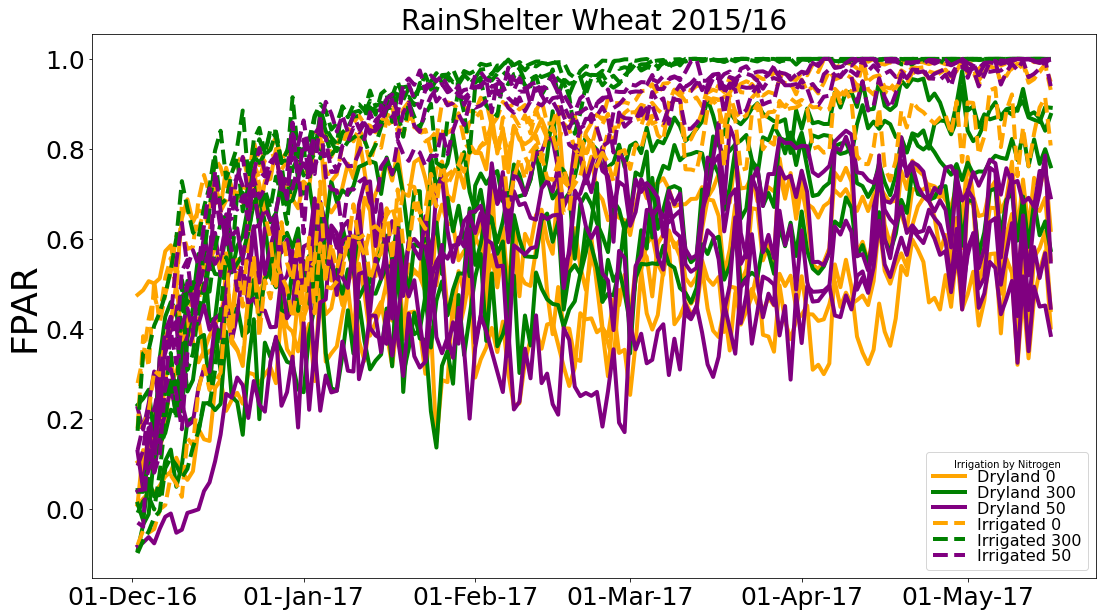

In [4]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(FPAR,ax,GPs,4)
plt.ylabel('FPAR', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')

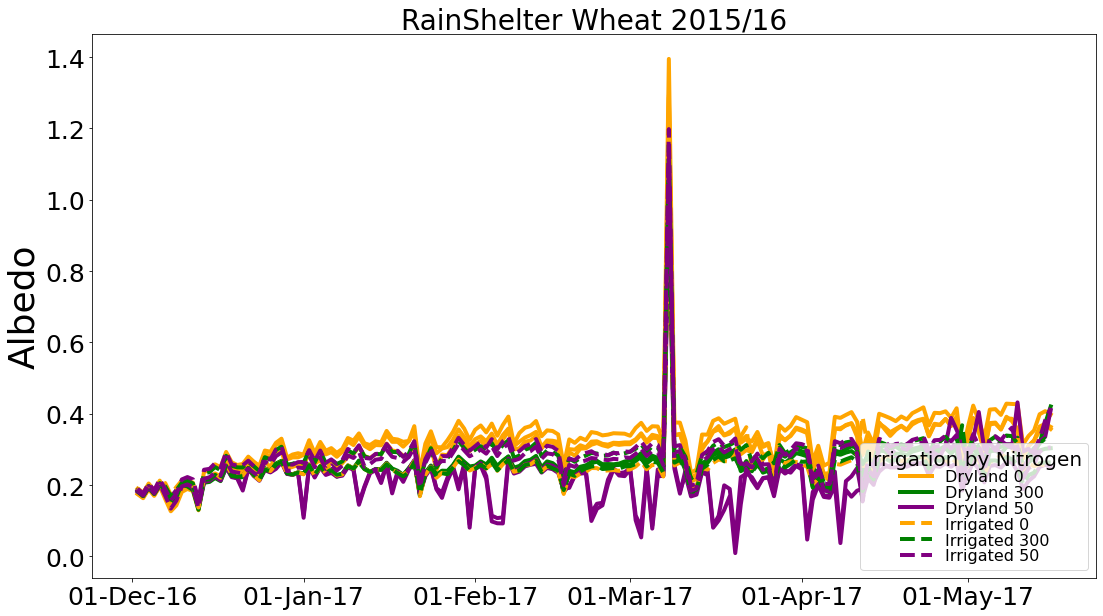

In [5]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(Albedo,ax,GPs,4)
plt.ylabel('Albedo', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')
ledg.get_title().set_fontsize(20)

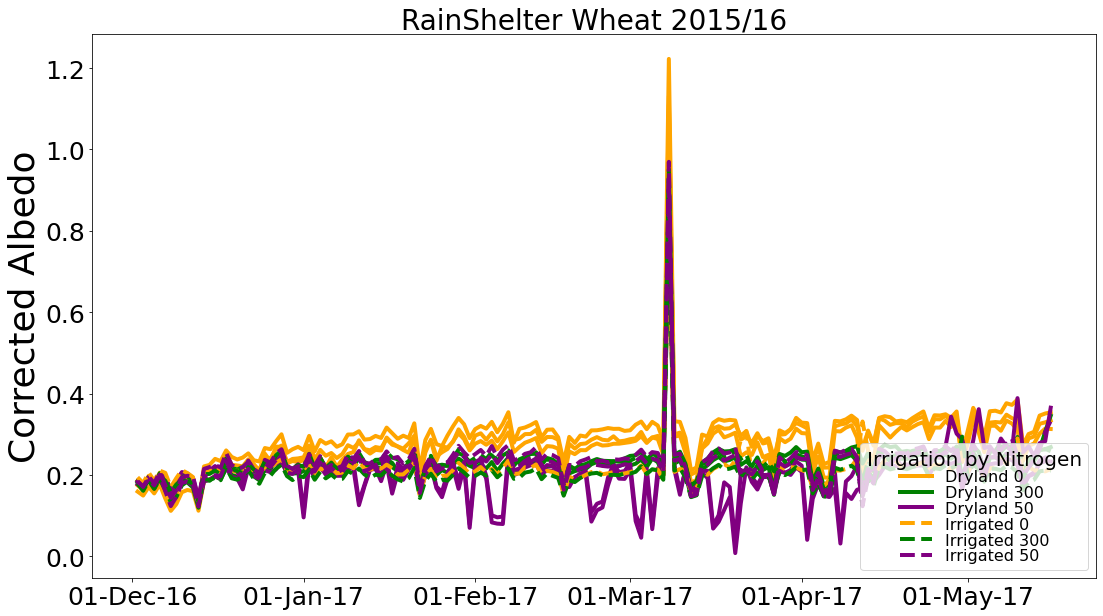

In [6]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AlbedoCorrected,ax,GPs,4)
plt.ylabel('Corrected Albedo', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')
ledg.get_title().set_fontsize(20)

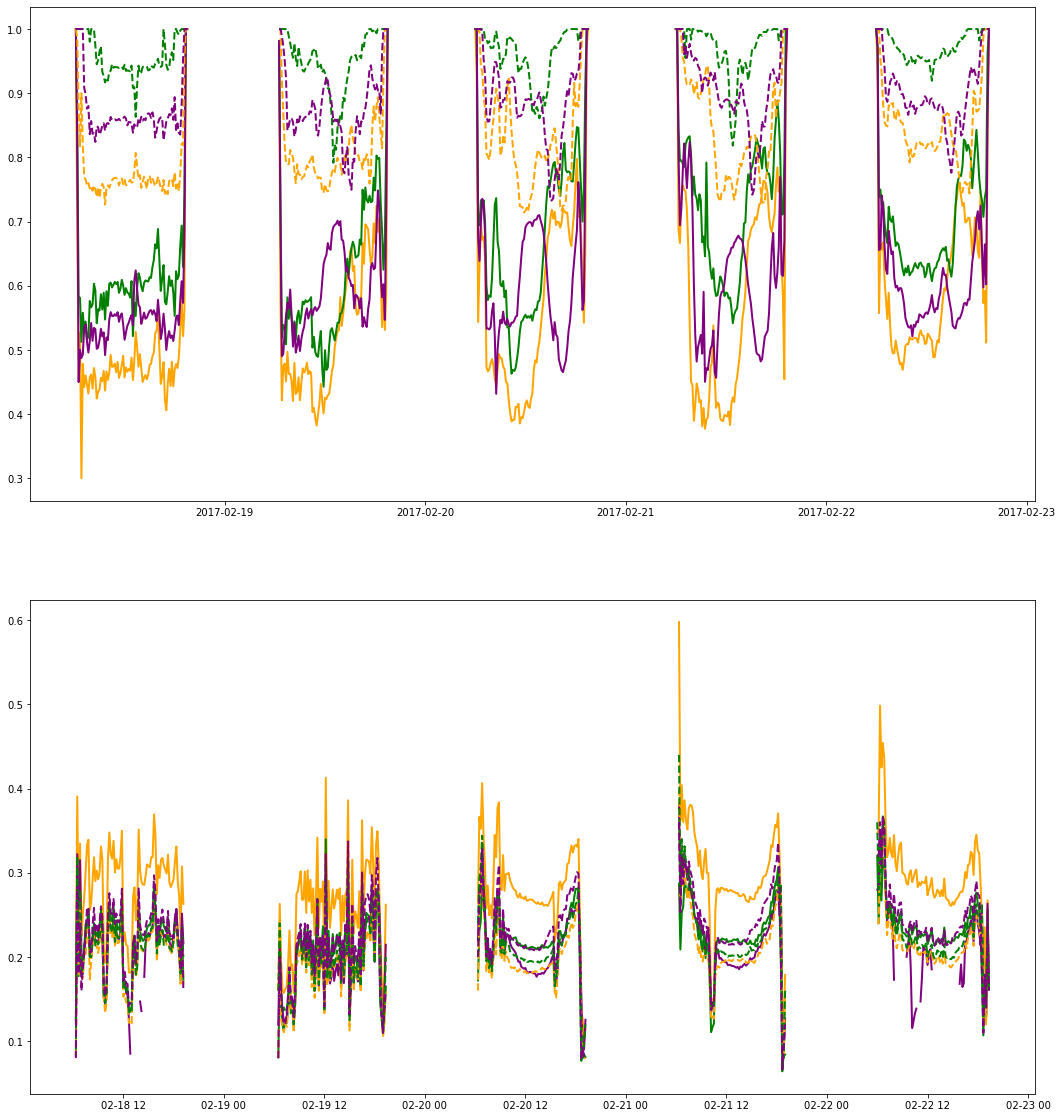

In [7]:
Start = '2017-02-18'
End = '2017-02-22'
Graph = plt.figure(figsize=(18,20))
ax = Graph.add_subplot(2,1,1)
#Calculate treatment means
FPARHourlyMeans = FPARhourly.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
Sample  = FPARHourlyMeans.loc[Start:End,:]
GH.AddIndexedPlot(Sample,ax,GPs,2)

ax = Graph.add_subplot(2,1,2)
AlbedoHourlyCorrectedMeans = AlbedoHourlyCorrected.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
Sample  = AlbedoHourlyCorrectedMeans.loc[Start:End,:]
GH.AddIndexedPlot(Sample,ax,GPs,2)


# Look at the relationship between albido and radiation interception

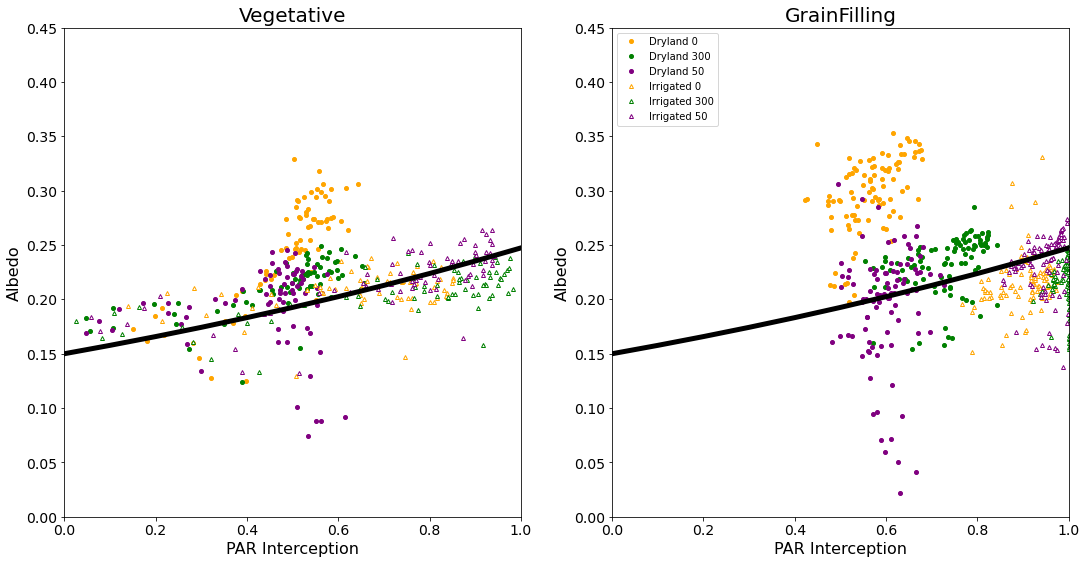

In [8]:
FunctX = np.float64(range(0,11,1))/10
FunctY = []
FunctYBiasCor = []
for x in FunctX:
    value = .15 * np.exp(x*.5)
    FunctY.append(value)
Turn = '2017-02-10'
Start = '2016-12-01'
End = '2017-05-15'
DailyAlbedoMeans = AlbedoCorrected.loc[Start:Turn,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()
DailyFPARMeans = FPAR.loc[Start:Turn,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()

Graph = plt.figure(figsize = (18,9))
ax = Graph.add_subplot(1,2,1)
GH.AddIndexedXY(DailyFPARMeans,DailyAlbedoMeans,ax,GPs,4)

plt.plot(FunctX,FunctY,'-',color = 'k',linewidth=5)
plt.ylim(0,0.45)
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Vegetative',fontsize=20)
plt.ylabel('Albedo',fontsize=16)
plt.xlabel('PAR Interception',fontsize=16)

DailyAlbedoMeans = AlbedoCorrected.loc[Turn:End,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()
DailyFPARMeans = FPAR.loc[Turn:End,:].groupby(
    level=['Irrigation','Nitrogen'],axis=1).mean()

ax = Graph.add_subplot(1,2,2)
GH.AddIndexedXY(DailyFPARMeans,DailyAlbedoMeans,ax,GPs,4)

plt.plot(FunctX,FunctY,'-',color ='k',linewidth=5)
plt.ylim(0,0.45)
plt.xlim(0,1)
plt.title('GrainFilling',fontsize=20)
plt.ylabel('Albedo',fontsize=16)
plt.xlabel('PAR Interception',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = 2)

### The effects of FPAR on albedo can be described using an exponential function 
$Albedo = 0.15 * e^{(FPAR*0.5)}$
Where 0.15 represents the bare soil albedo and $e^{(FPAR*0.5)}$ is the effect of crop FPAR. These coeffocients are taken from barley and better fits may be needed for wheat

## Calculate estimated Albedo for all plots from FPAR data

## Bring in NDVI data and convert to FPAR estimate

In [10]:
NDVI = pd.read_excel('.\RawDatafiles\Canopy.xlsx',engine='openpyxl',sheet_name='NDVI',
                     index_col=[0],header=[0,1,2])
NDVIDF = pd.concat([NDVI],axis=1,keys=['NDVI'],names=['Measurement'])
GH.SortFrame(NDVIDF)

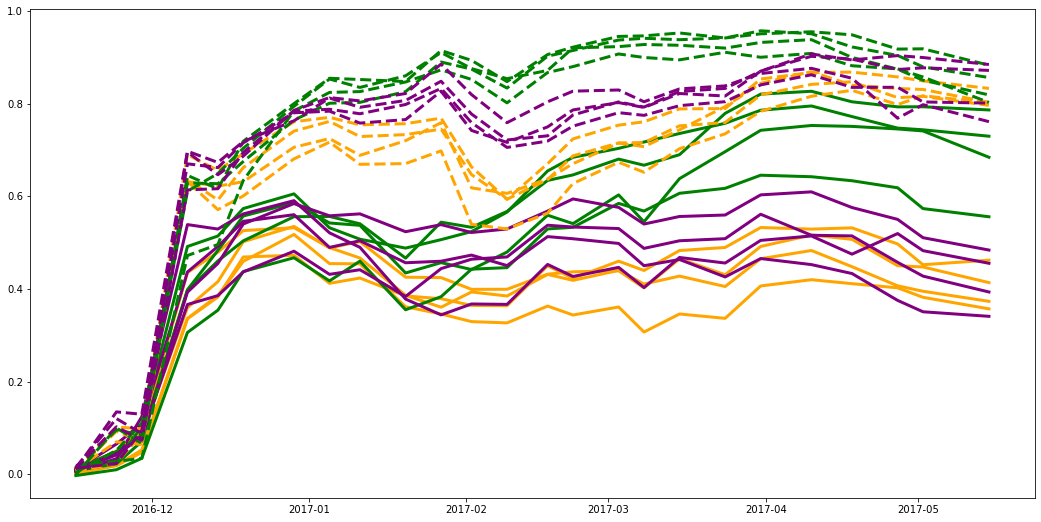

In [11]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(NDVIDF.NDVI,ax,GPs,3)

### Extrapolate fPAR estimated from NDVI out to daily values using temperature accumulation

In [12]:
TempAccum = Data.AirTemperature.resample('d').mean().cumsum()
DailyDates= TempAccum.index
DailyfPAREstInterp = pd.DataFrame(index = TempAccum.index, columns = NDVI.columns)
for plot in DailyfPAREstInterp.columns:
    DailyfPAREstInterp.loc[:,plot] = np.interp(TempAccum, 
                                               TempAccum.reindex(NDVI.index).loc[:,('Expt','Expt','Expt')].values,
                                               NDVI.loc[:,plot].values)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


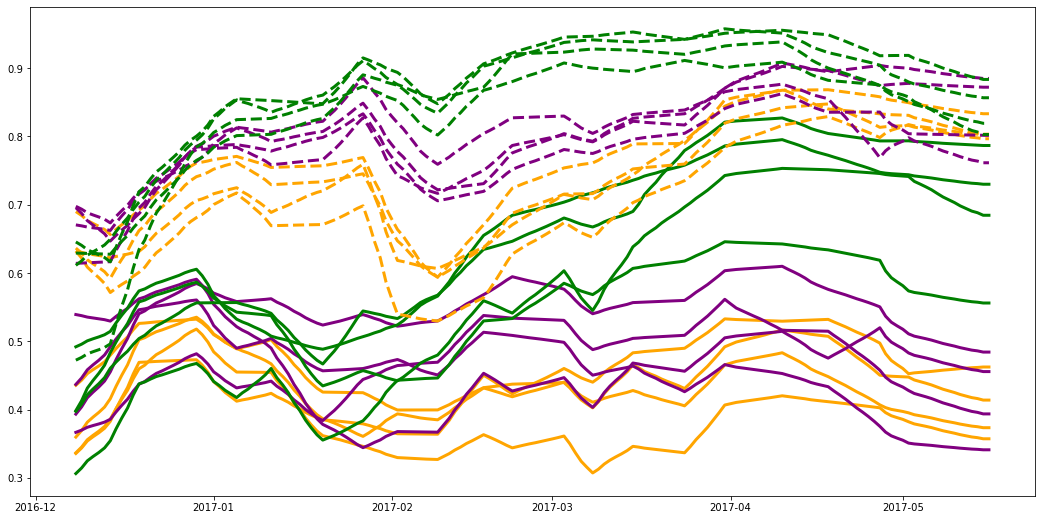

In [13]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(DailyfPAREstInterp,ax,GPs,3)

In [41]:
DailyfPAREstInterp.to_pickle('.\DataFrames\DailyfPAREstInt.pkl')

## Calculate estimated Albedo for all plots from FPAR data

In [14]:
def EstAlbedo(FPAR,coeff,intercept):
    _return = np.multiply(FPAR,coeff)
    _return = np.exp(_return)
    _return = np.multiply(_return,intercept)
    return _return

In [15]:
AlbedoCorEstInt = FPAR.copy()
AlbedoCorEstInt = pd.concat([AlbedoCorEstInt],axis=1,keys=['AlbedoCorEstInt'],names=['Measurement'])
for plot in AlbedoCorEstInt.AlbedoCorEstInt:
    AlbedoCorEstInt.AlbedoCorEstInt.loc[:,plot] = EstAlbedo(DailyfPAREstInterp.loc[:,plot],0.5,0.15)

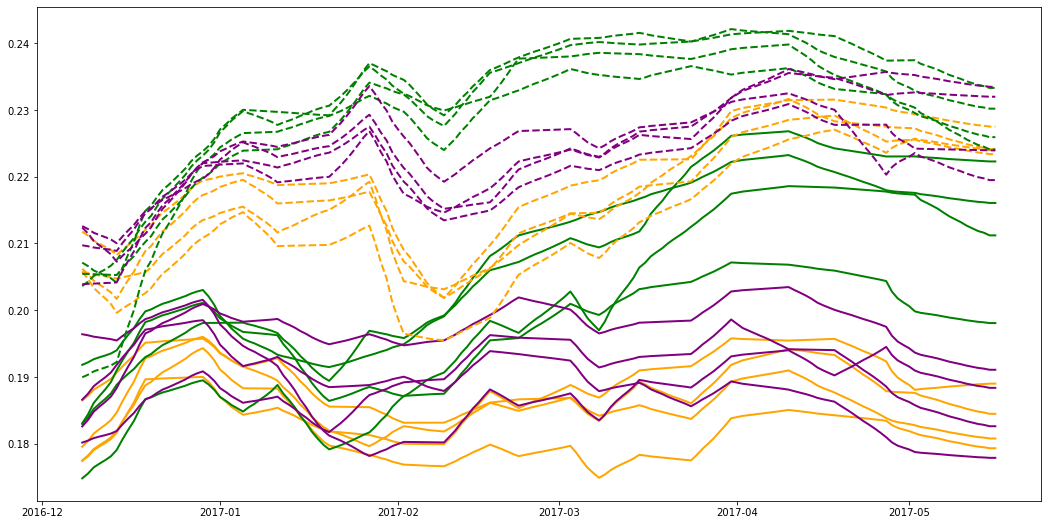

In [16]:
Graph = plt.figure(figsize=(18,20))
ax = Graph.add_subplot(2,1,1)
GH.AddIndexedPlot(AlbedoCorEstInt.AlbedoCorEstInt,ax,GPs,2)

In [45]:
AlbedoCorEstInt.AlbedoCorEstInt.to_pickle('.\DataFrames\DailyAlbedoCorEstInt.pkl')

## Bring in the Sunscan data

In [18]:
Cover = pd.read_excel('.\RawDatafiles\Canopy.xlsx',engine='openpyxl',sheet_name='Sunscan',
                     index_col=[0],header=[0,1,2])
SSFPARDF = pd.concat([Cover],axis=1,keys=['SunScanCover'],names=['Measurement'])
GH.SortFrame(SSFPARDF)

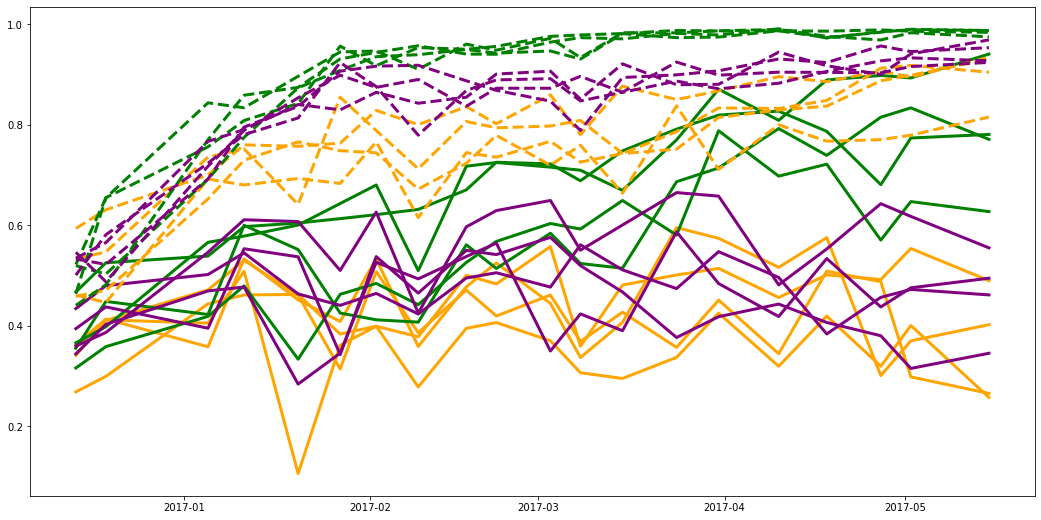

In [19]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(SSFPARDF.SunScanCover,ax,GPs,3)

In [20]:
MeanTemp = Data[('AirTemperature','Expt','Expt','Expt')].resample('D').mean().to_frame()
MeanTemp.AirTemperature.where(MeanTemp.AirTemperature>-10,10,inplace=True) #Replace junk data at start with estimates
MeanTemp[('AcummTT','Expt','Expt','Expt')]= MeanTemp['AirTemperature'].cumsum()
MeanTemp.columns.names = Data.columns.names

## Stick all the data into one data frame

In [21]:
#Give the FPAR dataframe a measurement lable
FPAR = FPAR.transpose()
FPAR['Measurement'] = 'FPAR'
FPAR = FPAR.set_index('Measurement',append=True)
FPAR = FPAR.reorder_levels(['Measurement','Irrigation','Nitrogen','Block'])
FPAR = FPAR.transpose()
FPAR.index = pd.to_datetime(FPAR.index)

#Give the AlbedoCorrected dataframe a measurement lable
AlbedoCorrected = AlbedoCorrected.transpose()
AlbedoCorrected['Measurement'] = 'AlbedoCorrected'
AlbedoCorrected = AlbedoCorrected.set_index('Measurement',append=True)
AlbedoCorrected = AlbedoCorrected.reorder_levels(['Measurement','Irrigation','Nitrogen','Block'])
AlbedoCorrected = AlbedoCorrected.transpose()
AlbedoCorrected.index = pd.to_datetime(AlbedoCorrected.index)

DailyData = FPAR.join(AlbedoCorrected)
DailyData = DailyData.join(NDVIDF)
DailyData = DailyData.join(SSFPARDF)
DailyData = DailyData.join(MeanTemp)
DailyData.index = pd.DatetimeIndex(DailyData.index).normalize()

GH.SortFrame(DailyData)

In [37]:
DailyData.loc[:,("FPAR","Dryland","300")].mean(axis=1)

Date
2016-12-02    0.047815
2016-12-03    0.056392
2016-12-04    0.107488
2016-12-05    0.107240
2016-12-06    0.195528
                ...   
2017-05-12    0.772145
2017-05-13    0.812285
2017-05-14    0.775477
2017-05-15    0.792882
2017-05-16    0.775898
Freq: D, Length: 166, dtype: float64

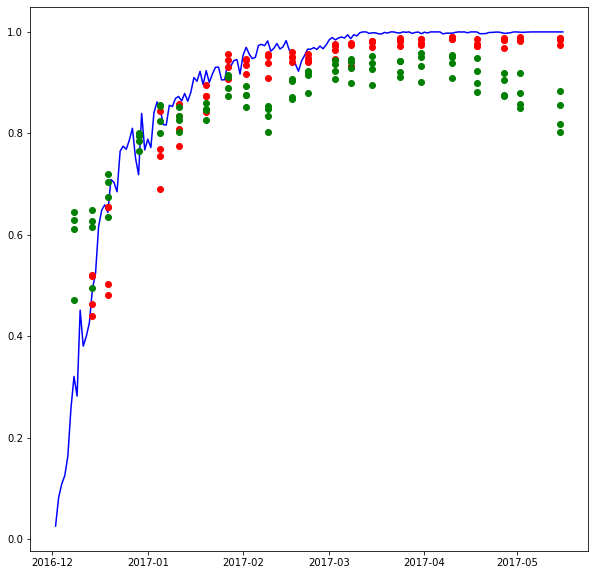

In [77]:
graph = plt.figure(figsize=(10,10))
plt.plot(DailyData.loc[:,("FPAR","Irrigated","300")].mean(axis=1),color='blue')
plt.plot(DailyData.loc[:,("SunScanCover","Irrigated","300")],'o',color='red')
plt.plot(DailyData.loc[:,("NDVI","Irrigated","300")],'o',color='green')

In [72]:
exportdata = DailyData.loc[:,['FPAR','NDVI']].groupby(['Measurement','Irrigation','Nitrogen'],axis=1).mean().stack().stack()

In [73]:
exportdata.index = exportdata.index.swaplevel(0,2)

In [74]:
exportdata.sort_index(inplace=True)

In [70]:
exportdata.to_excel("RadData.xlsx")

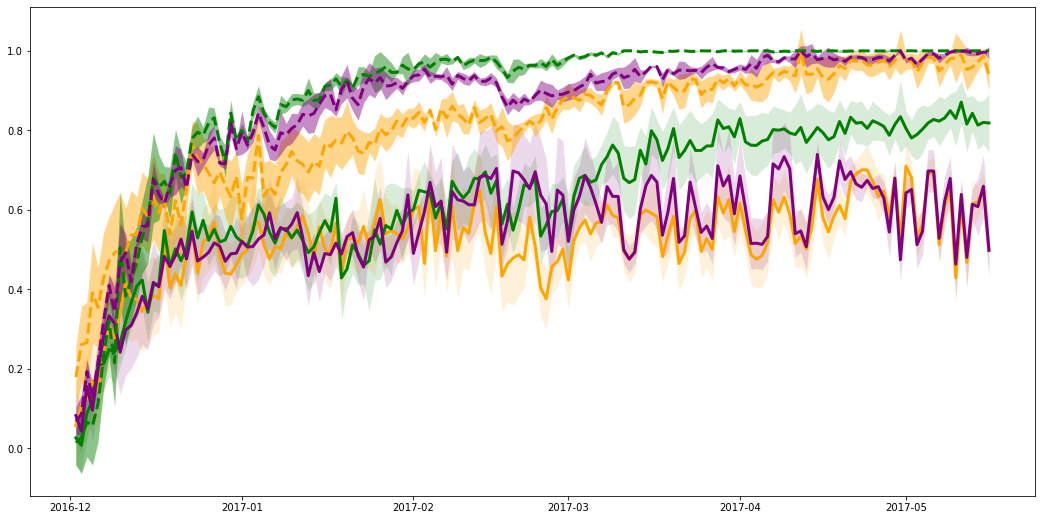

In [22]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(DailyData.FPAR,ax,GPs,3)

In [51]:
Cols = pd.MultiIndex.from_product([['Dryland','Irrigated'],['0','50','300']],names=['Irrigation','Nitrogen'])
Coeffs = pd.DataFrame(index=['A','B','C'],columns=Cols,)
Coeffs.loc[:,('Dryland','0')]   = [0.85,0.35,0.50]
Coeffs.loc[:,('Dryland','50')]   = [0.85,0.35,0.50]
Coeffs.loc[:,('Dryland','300')]  = [0.85,0.35,0.50]
Coeffs.loc[:,('Irrigated','0')]  = [0.85,0.35,0.60]
Coeffs.loc[:,('Irrigated','50')]  = [0.85,0.35,0.50]
Coeffs.loc[:,('Irrigated','300')] = [0.85,0.35,0.40]
Coeffs

Irrigation Dryland             Irrigated            
Nitrogen         0    50   300         0    50   300
A             0.85  0.85  0.85      0.85  0.85  0.85
B             0.35  0.35  0.35      0.35  0.35  0.35
C             0.50  0.50  0.50      0.60  0.50  0.40

(0, 1.1)

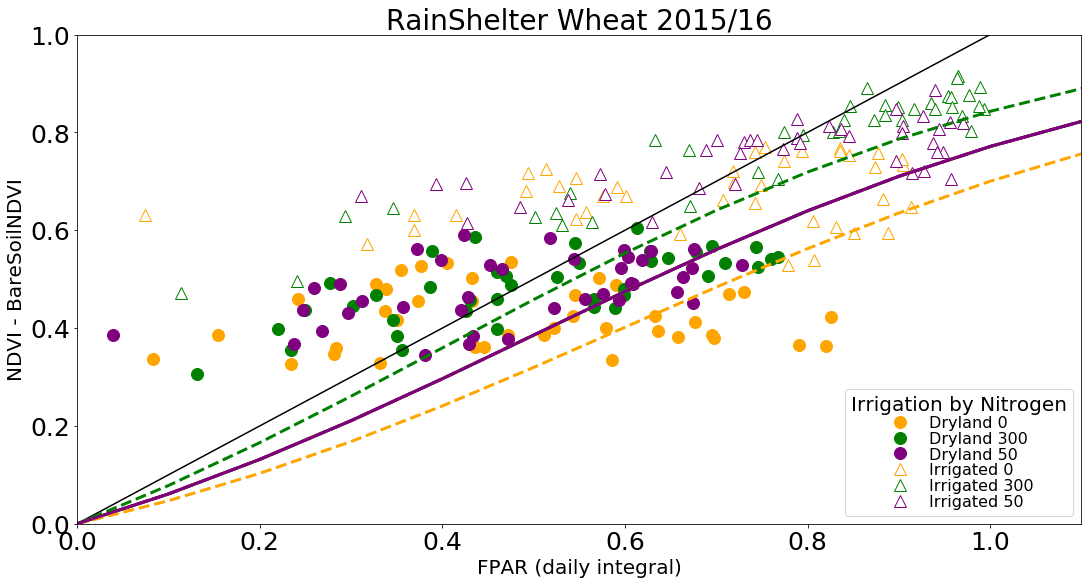

In [52]:
Graph = plt.figure(figsize=(18,9))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedXY(DailyData.loc[:Turn,'FPAR'],
                DailyData.loc[:Turn,'NDVI'],ax,GPs,12)
plt.xlabel('FPAR (daily integral)', fontsize=20)
plt.ylabel('NDVI - BareSoilNDVI', fontsize=20)
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')
ledg.get_title().set_fontsize(20)
plt.plot([0,1],[0,1],'-k')

for irr in GPs.F1Levels:
    for nit in GPs.F2Levels:
        xfit = np.float64(range(20))/10
        yfit = []
        A = Coeffs.loc['A',(irr,nit)]
        B = Coeffs.loc['B',(irr,nit)]
        C = Coeffs.loc['C',(irr,nit)]
        for xf in xfit:
            #
            yf = A * 1 / (1 + np.exp(-(xf -C) /B));
            y0 = A * 1 / (1 + np.exp(-(0 - C) /B));
            ydiffProp = (y0/(A + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
        plt.plot(xfit,yfit,GPs.StyleFrame.loc[(irr,nit),'Lin'],color=GPs.StyleFrame.loc[(irr,nit),'Col'],linewidth=3)
plt.ylim(0,1)
plt.xlim(0,1.1)

In [53]:
end = '2014-12-31'
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
Graph = plt.figure(figsize = (18,10))
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
A = [0.65,0.66,0.65,0.65]
B = [.16,.17,.2,.15]
C = [.45,.48,.5,.4]
linestyles = ['--','--','-','-']
pos = 0
#cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        NDVI = np.subtract(DailyData.loc['2014-11-07':end,('NDVI',Cult,Irr)].dropna(),
                           BareSoilNDVI.loc['2014-11-07':end,'Low'])
        PAR = DailyData.loc[NDVI.index,('FPAR',Cult,Irr)]        
        plt.plot(PAR,NDVI.loc[:,PAR.columns],'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        xfit = np.float64(range(20))/10
        yfit = []
        for xf in xfit:
            #
            yf = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(xf -Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            y0 = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(0 - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            ydiffProp = (y0/(Coeffs.loc['A',(Cult,Irr)] + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
            #print(str(xf)+" "+str(yf)+" "+str(y0)+" "+str(ydiffProp))
        plt.plot(xfit,yfit,linestyles[pos],color=irrigColors[pos],linewidth=3)
        pos += 1
        #cultpos+=1
plt.ylim(0,1)
plt.xlim(0,1.1)
plt.xlabel('FPAR (daily integral)', fontsize=20)
plt.ylabel('NDVI - BareSoilNDVI', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


KeyError: ('NDVI', 'Dash', 'Low')

<Figure size 1296x720 with 0 Axes>

The function fitted to data is a standard sigmoid:  
$ y = A * 1/(1+e^{-(x-C)/B})$  
that has been rescaled to pass through the origin:  
$ y = (A * 1/(1+e^{-(x-C)/B}) - y0)/(1-yDiffprop)$  
where $y0$ is the value of $y$ from the unscaled sigmoid where $x = 0$:  
$ y0 =  A * 1/(1+e^{-(0-C)/B})$
and $yDiffprop$ is the proportion of $A$ that is not FPARed by the unscaled function and is given by:   
$yDiffprop = y0/(A+y0)$

###To correct NDVI Data to be equivelent to logged PAR interception
Rearanging the scaled sigmoid to solve for x  
$y = (A * 1/(1+np.exp(-(x-C)/B))-y0)/(1-yDiffprop)$
$y*(1-yDiffprop) = A * 1/(1+np.exp(-(x-C)/B))-y0$
$(y*(1-yDiffprop))+y0 = A * 1/(1+np.exp(-(x-C)/B))$  
$((y*(1-yDiffprop))+y0)/A = 1/(1+np.exp(-(x-C)/B))$  
$1/(((y*(1-yDiffprop))+y0)/A) = 1+np.exp(-(x-C)/B)$  
$1/(((y*(1-yDiffprop))+y0)/A)-1 = np.exp(-(x-C)/B)$  
$np.log(1/(((y*(1-yDiffprop))+y0)/A)-1) = -(x-C)/B$  
$np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B = -(x-C)$  
$-(np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B) = x-C$  
$-(np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B)+C = x$  
  
$NDVIFPAR = -(np.log(1/(((y*(1-yDiffprop))+y0)/A)-1)*B)+C$

# NDVI to FPARgreen estimate in a function

In [ ]:
def NVDItoFPARGreen(A,B,C,NDVI):
    y0 = A * 1 / (1 + np.exp(-(0 - C) / B));
    #print(y0)
    yDiffprop = (y0/(A + y0))*2
    #print(yDiffprop)
    FPARestimated = -(np.log(1/(((NDVI*(1-yDiffprop))+y0)/A)-1)*B)+C
    #print(FPARestimated)
    if np.isnan(FPARestimated):
        FPARestimated = 1
    if FPARestimated > 1:
        FPARestimated = 1
    if NDVI <= 0:
        FPARestimated = 0
    return FPARestimated

## Function to hold FPAR at maximum value as NDVI declines

In [ ]:
def FPARGreenToFPAR(FPARGreen):
    maxGreen = 0
    pos = 0
    for row in FPARGreen:
        if row < maxGreen:
            FPARGreen[pos] = maxGreen
        if row > maxGreen:
            maxGreen = FPARGreen[pos]
        pos+=1
    return FPARGreen

In [ ]:
FPAREst_Columns = [('FPAREst','Dash','Low','1'),
('FPAREst','Dash','Low','2'),
('FPAREst','Dash','Low','3'),
('FPAREst','Dash','Low','4'),
('FPAREst','Dash','Mid','1'),
('FPAREst','Dash','Mid','2'),
('FPAREst','Dash','Mid','3'),
('FPAREst','Dash','Mid','4'),
('FPAREst','Dash','High','1'),
('FPAREst','Dash','High','2'),
('FPAREst','Dash','High','3'),
('FPAREst','Dash','High','4'),
('FPAREst','Omaka','Low','1'),
('FPAREst','Omaka','Low','2'),
('FPAREst','Omaka','Low','3'),
('FPAREst','Omaka','Low','4'),
('FPAREst','Omaka','Mid','1'),
('FPAREst','Omaka','Mid','2'),
('FPAREst','Omaka','Mid','3'),
('FPAREst','Omaka','Mid','4'),
('FPAREst','Omaka','High','1'),
('FPAREst','Omaka','High','2'),
('FPAREst','Omaka','High','3'),
('FPAREst','Omaka','High','4')]

In [ ]:
NVDItoFPARGreen(Coeffs.loc['A',('Dash','Low')],Coeffs.loc['B',('Dash','Low')],Coeffs.loc['C',('Dash','Low')], \
                         0.45) 

In [ ]:
FPARestimatedColumnsMI = pd.MultiIndex.from_tuples(FPAREst_Columns,names=('Measurement','Cultivar','Irrigation','Block'))
FPARestimated = pd.DataFrame(index=DailyData['NDVI'].dropna().index,columns=FPARestimatedColumnsMI)
FPARGreenEstimated = pd.DataFrame(index=DailyData['NDVI'].dropna().index,columns=FPARestimatedColumnsMI)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low','Mid','High']
Blocks = ['1','2','3','4']
Pos = 0
for Cult in Cultivars:
    for Irrig in Irrigations:
        for Block in Blocks:
            FPARGreen = \
            [NVDItoFPARGreen(Coeffs.loc['A',(Cult,Irrig)],Coeffs.loc['B',(Cult,Irrig)],Coeffs.loc['C',(Cult,Irrig)], \
                         DailyData[('NDVI',Cult,Irrig,Block)].dropna().loc[date] - BareSoilNDVI.loc[date,('Low','BareSoil')]) \
             for date in FPARestimated.index]
            FPARGreenEstimated[('FPAREst',Cult,Irrig,Block)] = FPARGreen
            FPARestimated[('FPAREst',Cult,Irrig,Block)] = \
            FPARGreenToFPAR(FPARGreen)
    Pos+=1

FPARestimated.groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
FPARGreenEstimated.groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

## Now we have estimates of FPAR based on NDVI from each plot.  extrapolate out to daily values

In [ ]:
DailyEstimates = MeanTemp.join(FPARestimated)
DailyEstimates.loc['2014-11-02','FPAREst'] = 0 ##Put a zero value at the start of the experiment
DailyEstimates.loc['2015-02-20','FPAREst'] = 0 ##Put a zero value at the end of the experiment
SortFrame(DailyEstimates)

In [ ]:
DailyGreenEstimates = MeanTemp.join(FPARGreenEstimated)
DailyGreenEstimates.loc['2014-11-02','FPAREst'] = 0 ##Put a zero value at the start of the experiment
DailyGreenEstimates.loc['2015-02-20','FPAREst'] = 0 ##Put a zero value at the end of the experiment
SortFrame(DailyGreenEstimates)

In [ ]:
Dates = DailyEstimates.loc[:,('FPAREst','Dash','High','1')].dropna().index
for plot in FPAREst_Columns:
    xarray = DailyEstimates.loc[Dates,('AcummTT','Expt','Expt','Expt')].values
    yarray = DailyEstimates.loc[Dates,plot].values
    DailyEstimates.loc[:,plot] = np.interp(DailyEstimates.loc[:,('AcummTT','Expt','Expt','Expt')],xarray,yarray)

In [ ]:
Dates = DailyGreenEstimates.loc[:,('FPAREst','Dash','High','1')].dropna().index
for plot in FPAREst_Columns:
    xarray = DailyGreenEstimates.loc[Dates,('AcummTT','Expt','Expt','Expt')].values
    yarray = DailyGreenEstimates.loc[Dates,plot].values
    DailyGreenEstimates.loc[:,plot] = np.interp(DailyGreenEstimates.loc[:,('AcummTT','Expt','Expt','Expt')],xarray,yarray)

In [ ]:
DailyEstimates.loc[:,('FPAREst','Dash')].plot(figsize=(18,10))

In [ ]:
DailyGreenEstimates.loc[:,('FPAREst','Dash')].plot(figsize=(18,10))

In [ ]:
DailyEstimates.loc[:,'FPAREst'].groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
DailyGreenEstimates.loc[:,'FPAREst'].groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
DailyEstimates.loc[:,'FPAREst'].to_pickle('.\DataFrames\DailyFPAREstInt.pkl')

In [ ]:
FPARGreenEstimated.loc[:,'FPAREst'].to_pickle('.\DataFrames\FPARGreenEstimated.pkl')

## Now lets get a daily estimate of albido for each plot using daily FPAR estimates the the bias corrected albido function from above

$AlbedoBiasCor = 0.15 * np.exp(FPAR*.6)$

In [ ]:
def EstAlbedo(FPAR,coeff):
    _return = np.multiply(FPAR,coeff)
    _return = np.exp(_return)
    _return = np.multiply(_return,0.15)
    return _return

In [ ]:
EstAlbedo(0,0.6)

In [ ]:
Cultivars = ['Dash','Omaka']
coeffs = [0.55, 0.6]
CultPos=0
for Cult in Cultivars:
    for Irrig in Irrigations:
        for Block in Blocks:
            DailyEstimates.loc[:,('AlbedoCorEstInt',Cult,Irrig,Block)] = EstAlbedo(DailyEstimates.loc[:,('FPAREst',Cult,Irrig,Block)],coeffs[CultPos])
    CultPos+=1

In [ ]:
DailyEstimates.loc[:,'AlbedoCorEstInt'].groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10))

In [ ]:
DailyEstimates.loc[:,'AlbedoCorEstInt'].to_pickle('.\DataFrames\DailyAlbedoCorEstInt.pkl')

In [ ]:
DailyEstimates.loc[:,'AlbedoCorEstInt']

In [ ]:
Graph = plt.figure(figsize=(18,20))

#fPAR Graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
alphas = [0.2,0.3]
fig = Graph.add_subplot(4,2,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].index
        Med = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].mean(axis=1)
        SEM = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$fPAR$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-10-20',0.95,'(a)',fontsize=16)

#albedo Graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
lines = ['--','-']
colors = ['r','b']
alphas = [0.2,0.3]
fig = Graph.add_subplot(4,2,6)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].index
        Med = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].mean(axis=1)
        SEM = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0.1,.35)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel(r'$\alpha_{cor}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-10-20',0.33,'(f)',fontsize=16)

#Radiation interception calibration Graph 
end = '2014-12-31'
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
A = [0.5,0.65,0.65,0.65]
B = [.16,.17,.17,.15]
C = [.45,.5,.5,.45]
linestyles = ['--','--','-','-']
fig = Graph.add_subplot(4,2,3)
pos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        NDVI = np.subtract(DailyData.loc['2014-11-07':end,('NDVI',Cult,Irr)].dropna(),
                           BareSoilNDVI.loc['2014-11-07':end,'Low'])
        PAR = DailyData.loc[NDVI.index,('FPAR',Cult,Irr)]        
        fig.plot(PAR,NDVI,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        xfit = np.float64(range(20))/10
        yfit = []
        for xf in xfit:
            #
            yf = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(xf - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            y0 = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(0 - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            ydiffProp = (y0/(Coeffs.loc['A',(Cult,Irr)] + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
        fig.plot(xfit,yfit,linestyles[pos],color=irrigColors[pos],linewidth=3)
        pos += 1
plt.ylim(0,0.8)
plt.xlim(0,1.1)
plt.xlabel('$fPAR_{green}$', fontsize=20, weight='bold')
plt.ylabel('$NDVI - NDVI_{BS}$', fontsize=20, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(labelsize=14) 
plt.text(0.05,0.7,'(c)', fontsize=16)

#Leaf Area Index Calibration Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
Slope = [0.8,1.3]
linestyles = ['--','-']
fig = Graph.add_subplot(4,2,4)
pos = 0
cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        for x in [0,1,2]:
            SunScan = DailyData.loc[MatchObsDates[x][1],('SunScanLAI',Cult,Irr)]
            LAI = DailyData.loc[MatchObsDates[x][0],('LAI',Cult,Irr)]
            plt.plot(LAI,SunScan,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        pos += 1
    xfit = np.float64(range(20))/2
    yfit = []
    for xf in xfit:
        yf = xf * Slope[cultpos] 
        yfit.append(yf)
    plt.plot(xfit,yfit,linestyles[cultpos],color='k')
    cultpos+=1
plt.xlabel('$Destructive LAI$', fontsize=20, weight='bold')
plt.ylabel('$Sun scan LAI$', fontsize=20, weight='bold')
plt.tick_params(labelsize=14)   
plt.ylim(0,10)
plt.xlim(0,10)
plt.text(0.5,9,'(d)',fontsize=16)

#NDVI Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
lines = ['--','-']
colors = ['r','g','b']
alphas = [0.2,0.3]
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].index
        Med = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].mean(axis=1)
        SEM = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$NDVI$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    
plt.text('2014-10-20',0.95,'(b)',fontsize=16)

#Leaf Area Index Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,5)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].index
        Med = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].mean(axis=1)
        SEM = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,8)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$LAI_{cor}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)   
plt.tight_layout
plt.text('2014-10-20',7.2,'(e)',fontsize=16)

#Albedo graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
fig = Graph.add_subplot(4,2,7)
pos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        Albedo = DailyData.loc['2014-11-07':Turn,('AlbedoCorrected',Cult,Irr)].mean(axis=1).dropna()
        PAR = DailyData.loc[Albedo.index,('FPAR',Cult,Irr)].mean(axis=1)
        fig.plot(PAR,Albedo,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize=15)
        pos += 1
FunctX = np.float64(range(0,11,1))/10
FunctY = []
for x in FunctX:
    value = .15 * np.exp(x*.6)
    FunctY.append(value)
fig.plot(FunctX,FunctY,linewidth=3)
plt.ylim(0.1,0.3)
plt.xlim(0,1.1)
plt.xlabel('$fPAR$', fontsize=20, weight='bold')
plt.ylabel(r'$\alpha_{cor}$', fontsize=20, weight='bold')
plt.text(0.05,0.285,'(g)',fontsize=16)

#Albedo time coarse
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid','High']
lines = ['--','-']
colors = ['r','g','b']
fig = Graph.add_subplot(4,2,8)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyEstimates.loc['2014-10-29':'2015-02-10',('AlbedoCorEstInt',Cul,Irr)].index
        Med = DailyEstimates.loc['2014-10-29':'2015-02-10',('AlbedoCorEstInt',Cul,Irr)].mean(axis=1)
        SEM = DailyEstimates.loc['2014-10-29':'2015-02-10',('AlbedoCorEstInt',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=alphas[CulPos])
        plt.plot(Ind,Med,lines[CulPos],color=colors[IrrPos], linewidth = 4,label = Cul + ' ' + Irr)
        IrrPos += 1
    CulPos+=1
plt.ylim(0.1,0.3)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel(r'$\alpha_{est}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)   
plt.tight_layout()
plt.text('2014-10-20',0.285,'(h)',fontsize=16)

In [ ]:
Graph = plt.figure(figsize=(18,6))


#NDVI Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
lines = ['--','-']
colors = ['r','g','b']
alphas = [0.2,0.3]
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(1,2,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].index
        Med = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].mean(axis=1)
        SEM = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$NDVI$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)    

#Leaf Area Index Graph
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(1,2,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].index
        Med = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].mean(axis=1)
        SEM = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize=10, label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,8)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$LAI_{cor}$', fontsize=20, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=14)   
plt.tight_layout

In [ ]:
#a
Graph = plt.figure(figsize=(7.6,9))
Msize = 5
#fPAR Graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
gaps = [3,3,0.0001,0.0001]
alphas = [0.15,0.15,0.3,0.3]
fig = Graph.add_subplot(4,2,1)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].index
        Med = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].mean(axis=1)
        SEM = FPAR.loc[:'2015-02-10',('FPAR',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha = alphas[CulPos],lw=0)
        plt.plot(Ind,Med,'-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize,color =irrigColors[IrrPos],dashes = (3,gaps[CulPos]),label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$F$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=8)    
plt.text('2014-10-20',0.95,'a',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)

#b
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
lines = ['--','-']
colors = ['r','g','b']
alphas = [0.15,0.3]
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].index
        Med = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].mean(axis=1)
        SEM = NDVIDF.loc[:'2015-02-10',('NDVI',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3,lw=0)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize, label = Cul + ' ' + Irr,color =irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(0,1.05)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$NDVI$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=9)    
plt.text('2014-10-20',0.95,'b',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)

#c 
end = '2014-12-31'
Cultivars =['Dash','Omaka']
Irrigations = ['Low','High']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
A = [0.5,0.65,0.65,0.65]
B = [.16,.17,.17,.15]
C = [.45,.5,.5,.45]
linestyles = ['--','--','-','-']
gaps = [3,3,0.0001,0.0001]
fig = Graph.add_subplot(4,2,3)
pos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        #remove bare soil values from NDVI
        NDVI = np.subtract(DailyData.loc['2014-11-07':end,('NDVI',Cult,Irr)].dropna(),
                           BareSoilNDVI.loc['2014-11-07':end,'Low'])
        PAR = DailyData.loc[NDVI.index,('FPAR',Cult,Irr)]        
        fig.plot(PAR,NDVI,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize = Msize)
        xfit = np.float64(range(20))/10
        yfit = []
        for xf in xfit:
            #
            yf = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(xf - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            y0 = Coeffs.loc['A',(Cult,Irr)] * 1 / (1 + np.exp(-(0 - Coeffs.loc['C',(Cult,Irr)]) / Coeffs.loc['B',(Cult,Irr)]));
            ydiffProp = (y0/(Coeffs.loc['A',(Cult,Irr)] + y0)) * 2
            yf = (yf-y0)/(1-ydiffProp)
            yfit.append(yf)
        fig.plot(xfit,yfit,'-',color=irrigColors[pos],linewidth=1,dashes = (3,gaps[pos]))
        pos += 1
plt.ylim(0,0.8)
plt.xlim(0,1.1)
plt.xlabel('$F_{green}$', fontsize=7, weight='bold',)
plt.ylabel('$NDVI - NDVI_{BS}$', fontsize=7, weight='bold')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tick_params(labelsize=9) 
plt.text(0.05,0.7,'c', fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
fig.xaxis.labelpad = 0

#d
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
Slope = [0.8,1.3]
linestyles = ['--','-']
fig = Graph.add_subplot(4,2,4)
pos = 0
cultpos = 0
for Cult in Cultivars:
    for Irr in Irrigations:
        for x in [0,1,2]:
            SunScan = DailyData.loc[MatchObsDates[x][1],('SunScanLAI',Cult,Irr)]
            LAI = DailyData.loc[MatchObsDates[x][0],('LAI',Cult,Irr)]
            plt.plot(LAI,SunScan,'o',mec = irrigColors[pos],mfc=cultColors[pos],markersize = Msize)
        pos += 1
    xfit = np.float64(range(20))/2
    yfit = []
    for xf in xfit:
        yf = xf * Slope[cultpos] 
        yfit.append(yf)
    plt.plot(xfit,yfit,linestyles[cultpos],color='k')
    cultpos+=1
plt.xlabel('$Destructive LAI$', fontsize=8, weight='bold')
plt.ylabel('$Sun scan LAI$', fontsize=8, weight='bold')
plt.tick_params(labelsize=9)   
plt.ylim(0,10)
plt.xlim(0,10)
plt.text(0.5,9,'d',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 0)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 0)
fig.xaxis.labelpad = 0

#e
Cultivars =['Dash','Omaka']
Irrigations = ['Low','Mid','High']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
fig = Graph.add_subplot(4,2,5)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].index
        Med = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].mean(axis=1)
        SEM = DailyData.loc[SSLAIDF.index,('SunScanLAICorrected',Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize, label = Cul + ' ' + Irr,color =irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(0,8)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel('$LAI$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=8)   
plt.tight_layout
plt.text('2014-10-20',7.2,'e',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)

#f
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'High']
lines = ['--','-']
colors = ['r','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','b','r','b']
alphas = [0.15,0.15,0.3,0.3]
gaps = [3,3,0.0001,0.0001]
fig = Graph.add_subplot(4,2,6)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].index
        Med = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].mean(axis=1)
        SEM = AlbedoCorrected.loc['2014-11-07':'2015-02-10',('AlbedoCorrected',Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha = alphas[CulPos],lw=0)
        plt.plot(Ind,Med,'-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],markersize = Msize,color =irrigColors[IrrPos],dashes = (3,gaps[CulPos]),label = Cul + ' ' + Irr)
        IrrPos += 1
        CulPos+=1
plt.ylim(0.1,.35)
plt.xlim('2014-10-15','2015-02-15')
plt.ylabel(r'$\xi_s$', fontsize=9, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.text('2014-10-20',0.33,'f',fontsize=9)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)


Graph.savefig('Fig_3.jpg',dpi=1000)

In [ ]:
RnSo = Data.IncomingRadnMJ.resample('d').sum()/Data.So.resample('d').sum()
RnSo.plot()

In [ ]:
def makeSeries(Var,Frame):
    SSeries= Frame.loc[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    #SSeries.index = SSeries.index.droplevel()
    return SSeries


In [ ]:
DetailsPlotsList = [('Dash','High','1'),('Dash','High','3'),('Dash','High','4'),
          ('Dash','Low','1'),('Dash','Low','3'),('Dash','Low','4'),
          ('Omaka','High','1'),('Omaka','High','3'),('Omaka','High','4'),
          ('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','4')]

Data.index.name='Date'
AllDataLong = Data.unstack()
Rr = AllDataLong.ReflectedRadnMJ
Rr.name = 'Rr'
AlbedoFrame = pd.DataFrame(Rr)
RsMJSeries = makeSeries('IncomingRadnMJ',AllDataLong)
RsKWSeries = makeSeries('IncomingRadnKW',AllDataLong)
PARoSeries = makeSeries('AboveCanopyPAR',AllDataLong)
PARoSeries = PARoSeries.groupby(level='Date').mean().loc[RsKWSeries.index.get_level_values(1)]
PARoSeries.index = RsKWSeries.index
SoSeries = makeSeries('So',AllDataLong)
for plot in DetailsPlotsList:
    AlbedoFrame.loc[plot,'RsMJ'] = RsMJSeries.values
    AlbedoFrame.loc[plot,'RsKW'] = RsKWSeries.values
    AlbedoFrame.loc[plot,'PARo'] = PARoSeries.values
    AlbedoFrame.loc[plot,'So'] = SoSeries.values
PARt = AllDataLong.BelowCanopyPAR
PARt.name = 'PARt'
AlbedoFrame = AlbedoFrame.join(PARt)

In [ ]:
AlbedoFrame.loc[:,'fPAR'] = 1-AlbedoFrame.loc[:,'PARt']/AlbedoFrame.loc[:,'PARo']
AlbedoFrame.loc[:,'albedo'] = AlbedoFrame.loc[:,'Rr']/AlbedoFrame.loc[:,'RsMJ']
AlbedoFrame.loc[:,'albedocor'] = AlbedoFrame.loc[:,'albedo'] * (1-0.2*AlbedoFrame.loc[:,'fPAR'])
AlbedoFrame.loc[:,'AlbedoEst'] = .15 * np.exp(AlbedoFrame.loc[:,'fPAR']*.6)
AlbedoFrame.loc[:,'Res'] = AlbedoFrame.loc[:,'albedocor'] - AlbedoFrame.loc[:,'AlbedoEst']
AlbedoFrame.loc[:,'RsSo'] = AlbedoFrame.loc[:,'RsMJ'] / AlbedoFrame.loc[:,'So']

In [ ]:
Graph = plt.plot(figsize=(18,10))

for cult in ['Dash','Omaka']:
    for irr in ['Low','High']:
        Filter = AlbedoFrame.loc[:,'RsMJ'] > 0.1
        yData = AlbedoFrame.loc[Filter].loc[:,'Res'].groupby(level=['Cultivar','Irrigation','Date']).mean().loc[(cult,irr)].resample('d').mean()
        xData =  AlbedoFrame.loc[Filter].loc[:,'fPAR'].groupby(level=['Cultivar','Irrigation','Date']).mean().loc[(cult,irr)].resample('d').mean()
        plt.plot(xData,yData,'o')
#plt.ylim(-1,1)

In [ ]:
RadnData.columns.isin(['AboveCanopyPAR','BelowCanopyPAR'],level=0)

In [ ]:
PARData = RadnData.loc[:,RadnData.columns.isin(['AboveCanopyPAR','BelowCanopyPAR'],level=0)].dropna(how='all')

In [ ]:
CleanedPARData = PARData.where(PARData.loc[:,'AboveCanopyPAR'].mean(axis=1)>0.1,np.nan).dropna(how='all')

In [ ]:
CleanerPARData = CleanedPARData.replace(to_replace='NaN',value='NA')

In [ ]:
LongPARData = CleanerPARData.unstack()

In [ ]:
LongPARData.to_csv('K:\Rainshelter\Barley_2014_15\PARData.dat',header=True)

## Estimate canopy height from LAI data

In [ ]:
#Make a data frame the same shape and indexing as LAI
Height = pd.DataFrame(columns = SSLAIDF.columns.droplevel(0), 
                      index = DailyData.loc[:,('SunScanLAICorrected')].index)
#Function to estimate height from LAI
def estHeight(LAI):
    Height = []
    for x in LAI.index:
        if x < datetime.datetime(2015,1,1,0,0):
            HeightGuess = LAI.loc[x] * 0.12
        else:
            HeightGuess = LAI.loc['2015-1-1'] * 0.12
        Height.append(HeightGuess)
    return Height
#Estimate height for each plot and stick in dataframe
for plot in Height.columns:
    Height.loc[:,plot] = estHeight(DailyData.loc[:,('SunScanLAICorrected')].loc[:,plot])

In [ ]:
Height.groupby(level=['Irrigation','Nitrogen'], axis=1).mean().plot(figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)

In [ ]:
Height.to_pickle('./DataFrames/HeightEstimated.pkl')

In [ ]:
FPARGreenEstimated.index.name='Clock.Today'
LongData = FPARGreenEstimated.groupby(level=['Irrigation','Nitrogen'],axis=1).mean().stack().stack()
LongData = LongData.reorder_levels(['Cultivar','Irrigation','Clock.Today'])
LongData.sort_index(inplace=True)
Cs = ['Dash','Omaka']
Is = ['High','Low','Mid']
SimNames = ['RS2014_15CultDashIrrHigh',
            'RS2014_15CultDashIrrLow',
            'RS2014_15CultDashIrrMed',
            'RS2014_15CultOmakaIrrHigh',
            'RS2014_15CultOmakaIrrLow',
            'RS2014_15CultOmakaIrrMed']
Dates = FPARGreenEstimated.dropna().index
SimIndex = pd.MultiIndex.from_product([SimNames,Dates],names=['SimulationName','Clock.Today'])
LongData.index = SimIndex
LongData.name='Barley.Leaf.CoverGreen'
pd.DataFrame(LongData).to_excel('RS14_15CoverGreen.xlsx',merge_cells=False)

In [ ]:
FPAR.index.name='Clock.Today'
LongData = FPAR.groupby(level=['Irrigation','Nitrogen'],axis=1).mean().stack().stack()
LongData = LongData.reorder_levels(['Cultivar','Irrigation','Clock.Today'])
LongData.sort_index(inplace=True)
Cs = ['Dash','Omaka']
Is = ['High','Low',]
SimNames = ['RS2014_15CultDashIrrHigh',
            'RS2014_15CultDashIrrLow',
            'RS2014_15CultOmakaIrrHigh',
            'RS2014_15CultOmakaIrrLow']
Dates = FPAR.dropna().index
SimIndex = pd.MultiIndex.from_product([SimNames,Dates],names=['SimulationName','Clock.Today'])
LongData.index = SimIndex
LongData.name='Barley.Leaf.CoverTotal'
pd.DataFrame(LongData).to_excel('RS14_15CoverTotal.xlsx',merge_cells=False)